In [21]:
# %pip install -U kaleido
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import copy
import significantdigits as sd

In [ ]:
#Remove failed subjects
# subjects_to_remove =  ['sub-#', 'sub-##', 'sub-###']
# hcsubjects_to_remove=['sub-####', 'sub-#####']

In [23]:
#Read data function for each threshold and removing subject failed in preprocessing
def Read_data(threshold):
    #ReadWconf data
    df=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableWConf_batch_1.pkl')
    df1=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableWConf_batch_2.pkl')
    df2=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableWConf_batch_3.pkl')
    df3=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableWConf_batch_4.pkl')
    df4=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableWConf_batch_5.pkl')

    all_dfs = [df, df1, df2, df3, df4]
    Results_tableWConf = pd.concat(all_dfs, ignore_index=True)


    ################################################################################################

    #Read NoConf data
    dfn=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableNoConf_batch_1.pkl')
    dfn1=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableNoConf_batch_2.pkl')
    dfn2=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableNoConf_batch_3.pkl')
    dfn3=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableNoConf_batch_4.pkl')
    dfn4=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableNoConf_batch_5.pkl')

    all_dfs = [dfn, dfn1, dfn2, dfn3, dfn4]
    Results_tableNoConf = pd.concat(all_dfs, ignore_index=True)  


    dfW = Results_tableWConf[~Results_tableWConf['subject'].isin(subjects_to_remove)]
    dfN= Results_tableNoConf[~Results_tableNoConf['subject'].isin(subjects_to_remove)]
    
    ###################################################################################################

    #Read healthy control
    dfWhc=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableWConf_batch_hc.pkl')
    dfNhc=pd.read_pickle(f'/home/ubuntu/Desktop/Thesis/overlap/allbatches/table_correther{threshold}/Result_tableNoConf_batch_hc.pkl')
    dfWhc = dfWhc[~dfWhc['subject'].isin(hcsubjects_to_remove)]
    dfNhc= dfNhc[~dfNhc['subject'].isin(hcsubjects_to_remove)]

    return dfW,dfN,dfWhc,dfNhc



In [24]:
dfW,dfN,dfWhc,dfNhc=Read_data(0.5)
alldfss_p=[dfW,dfWhc]
all_pop5=pd.concat(alldfss_p,ignore_index=True)



In [25]:
dfW,dfN,dfWhc,dfNhc=Read_data(0.4)
alldfss_g=[dfW,dfWhc]
all_pop4=pd.concat(alldfss_g,ignore_index=True)

In [26]:
dfW,dfN,dfWhc,dfNhc=Read_data(0.3)
alldfss_s=[dfW,dfWhc]
all_pop3=pd.concat(alldfss_s,ignore_index=True)

In [27]:
dfW,dfN,dfWhc,dfNhc=Read_data(0.2)
alldfss_d=[dfW,dfWhc]
all_pop2=pd.concat(alldfss_d,ignore_index=True)

In [28]:
dfW,dfN,dfWhc,dfNhc=Read_data(0.1)
alldfss_o=[dfW,dfWhc]
all_pop1=pd.concat(alldfss_o,ignore_index=True)

In [29]:
dfW,dfN,dfWhc,dfNhc=Read_data(0.05)
alldfss_ps=[dfW,dfWhc]
all_pop05=pd.concat(alldfss_ps,ignore_index=True)

In [ ]:
#Compute the variance across MCA repetitions for each subject, session, and acquisition
def makestdevNum_metric(df):
    """
    Calculate standard deviation across MCA repetitions for each subject, session, and acquisition.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing network metrics for different subjects, sessions, acquisitions and repetitions
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with standard deviations of metrics for each subject, session, and acquisition
    """
    # Define columns for metrics
    metric_columns = [
        'degree_(numericalVar)', 'betweeness_(numericalVar)', 
          'eigenvec_(numericalVar)',  'clusteringcoef_(numericalVar)',
        'smallworldness(numericalVar)', 'avg_shortestPathLength(numericalVar)'
    ]
    
    # Define info columns
    info_columns = ['subject', 'session', 'acquisition']
    
    # Pre-filter to exclude unwanted acquisitions for efficiency
    df_filtered = df[~df['acquisition'].isin(['acq-RLsplit1', 'acq-LRsplit1'])]
    
    # Create empty list to collect results
    results = []
    
    # Group by subject, session, acquisition to avoid nested loops
    for (subj, session, acquisition), group in df_filtered.groupby(['subject', 'session', 'acquisition']):
        # Collections for each metric across repetitions
        all_metrics = {
            'degree': [], 'betweeness': [], 'eigen': [], 
            'clustering': [], 'smallworld': [], 'shortestpath': []
        }
        
        # Collect metrics for all repetitions
        for _, row in group.iterrows():
            rep_num = row.get('repetition')
            if not isinstance(rep_num, str) or not rep_num.startswith('rep-'):
                continue
                
            # Only process if we have the necessary data
            if (isinstance(row.get('degree_centralities'), dict) and 
                isinstance(row.get('betweenness_centralities'), dict) and
                isinstance(row.get('eigenvector_centralities'), dict) and
                isinstance(row.get('clustering_coefficients'), dict)):
                
                # Extract metrics
                all_metrics['degree'].append(list(row['degree_centralities'].values()))
                all_metrics['betweeness'].append(list(row['betweenness_centralities'].values()))
                all_metrics['eigen'].append(list(row['eigenvector_centralities'].values()))
                all_metrics['clustering'].append(list(row['clustering_coefficients'].values()))
                
                # Add scalar metrics if they exist
                if 'small_worldness' in row:
                    all_metrics['smallworld'].append(row['small_worldness'])
                if 'avg_shortest_path_length' in row:
                    all_metrics['shortestpath'].append(row['avg_shortest_path_length'])
        
        # Only calculate stats if we have data
        if not all_metrics['degree']:
            continue
            
        # Calculate standard deviations
        result_row = {
            'subject': subj,
            'session': session,
            'acquisition': acquisition,
            'degree_(numericalVar)': [np.var(all_metrics['degree'], axis=0)],
            'betweeness_(numericalVar)': [np.var(all_metrics['betweeness'], axis=0)],
            'eigenvec_(numericalVar)': [np.var(all_metrics['eigen'], axis=0)],
            'clusteringcoef_(numericalVar)': [np.var(all_metrics['clustering'], axis=0)]
        }
        
        # Add scalar metrics if available
        if all_metrics['smallworld']:
            result_row['smallworldness(numericalVar)'] = np.var(all_metrics['smallworld'], axis=0)
        if all_metrics['shortestpath']:
            result_row['avg_shortestPathLength(numericalVar)'] = np.var(all_metrics['shortestpath'], axis=0)
            
        results.append(result_row)
    
    # Create DataFrame from results
    avrofStd_WithinSubject = pd.DataFrame(results)
    
    # Ensure proper data types for object columns
    for col in metric_columns:
        if col in avrofStd_WithinSubject.columns:
            avrofStd_WithinSubject[col] = avrofStd_WithinSubject[col].astype('object')
    
    return avrofStd_WithinSubject

In [ ]:
#Compute the variance across subjects for each repetition, session, and acquisition
def makestedvAnat_metric(df):
    """
    Calculate standard deviation of network metrics across subjects for each repetition, session, and acquisition.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing network metrics for different subjects, sessions, acquisitions and repetitions
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with standard deviations of metrics for each repetition, session, and acquisition
    """
    # Define columns for metrics
    metric_columns = [
        'degree_(AnatomicalVar)', 'betweeness_(AnatomicalVar)', 
         'eigenvec_(AnatomicalVar)', 'clusteringcoef_(AnatomicalVar)', 
        'smallworldness(AnatomicalVar)', 'avg_shortestPathLength(AnatomicalVar)'
    ]
    
    # Info columns
    info_columns = ['iteration', 'session', 'acquisition']
    
    # Pre-filter to exclude unwanted acquisitions for efficiency
    df_filtered = df[~df['acquisition'].isin(['acq-RLsplit1', 'acq-LRsplit1'])]
    
    # Create empty list to collect results
    results = []
    
    # First loop through repetitions (since we want to group by repetition)
    for rep in range(1, 11):
        rep_str = f'rep-{rep}'
        # Filter for current repetition
        rep_df = df_filtered[df_filtered['repetition'] == rep_str]
        
        if rep_df.empty:
            continue
            
        # Group by session and acquisition
        for (session, acquisition), group in rep_df.groupby(['session', 'acquisition']):
            # Collections for metrics across subjects
            all_metrics = {
                'degree': [], 'betweeness': [], 'eigen': [], 
                'clustering': [], 'smallworld': [], 'shortestpath': []
            }
            
            # Loop through subjects in this group
            for subject, subject_data in group.groupby('subject'):
                if subject_data.empty:
                    continue
                    
                # Get the first (and should be only) row for this subject in this repetition/session/acquisition
                row = subject_data.iloc[0]
                
                # Check if required data exists
                if (isinstance(row.get('degree_centralities'), dict) and 
                    isinstance(row.get('betweenness_centralities'), dict) and
                    isinstance(row.get('eigenvector_centralities'), dict) and
                    isinstance(row.get('clustering_coefficients'), dict)):
                    
                    # Extract metrics
                    all_metrics['degree'].append(list(row['degree_centralities'].values()))
                    all_metrics['betweeness'].append(list(row['betweenness_centralities'].values()))
                    all_metrics['eigen'].append(list(row['eigenvector_centralities'].values()))
                    all_metrics['clustering'].append(list(row['clustering_coefficients'].values()))
                    
                    # Add scalar metrics if they exist
                    if 'small_worldness' in row:
                        all_metrics['smallworld'].append(row['small_worldness'])
                    if 'avg_shortest_path_length' in row:
                        all_metrics['shortestpath'].append(row['avg_shortest_path_length'])
            # if((session=='1') & (acquisition=='acq-RL')):
            #     print(len(all_metrics['degree']))
            # Only calculate stats if we have enough data (at least 2 subjects)
            if len(all_metrics['degree']) < 2:
                continue
            # if ((session=='1') & (acquisition=='acq-RL')):
            #     print(len(all_metrics['degree']))
            # Calculate standard deviations
            result_row = {
                'iteration': f'iter_{rep}',
                'session': session,
                'acquisition': acquisition,
                'degree_(AnatomicalVar)': [np.var(all_metrics['degree'], axis=0)],
                'betweeness_(AnatomicalVar)': [np.var(all_metrics['betweeness'], axis=0)],
                # Note: Fixed a bug in the original code - eigenvec and clusteringcoef were swapped
                'eigenvec_(AnatomicalVar)': [np.var(all_metrics['eigen'], axis=0)],
                'clusteringcoef_(AnatomicalVar)': [np.var(all_metrics['clustering'], axis=0)]
            }
            
            # Add scalar metrics if available
            if all_metrics['smallworld']:
                result_row['smallworldness(AnatomicalVar)'] = np.var(all_metrics['smallworld'], axis=0)
            if all_metrics['shortestpath']:
                result_row['avg_shortestPathLength(AnatomicalVar)'] = np.var(all_metrics['shortestpath'], axis=0)
                
            results.append(result_row)
    
    # Create DataFrame from results
    avrofStd_BetweenSubject = pd.DataFrame(results)
    
    # Ensure proper data types for object columns
    for col in metric_columns:
        if col in avrofStd_BetweenSubject.columns:
            avrofStd_BetweenSubject[col] = avrofStd_BetweenSubject[col].astype('object')
    
    return avrofStd_BetweenSubject

In [32]:

df5_Wconf_num=makestdevNum_metric(all_pop5)
df5_Wconf_anat=makestedvAnat_metric(all_pop5)

#######################################
df4_Wconf_num=makestdevNum_metric(all_pop4)
df4_Wconf_anat=makestedvAnat_metric(all_pop4)

################################################
df3_Wconf_num=makestdevNum_metric(all_pop3)
df3_Wconf_anat=makestedvAnat_metric(all_pop3)


##########################################################
df2_Wconf_num=makestdevNum_metric(all_pop2)
df2_Wconf_anat=makestedvAnat_metric(all_pop2)


#########################################################

df1_Wconf_num=makestdevNum_metric(all_pop1)
df1_Wconf_anat=makestedvAnat_metric(all_pop1)

#######################################################################################

df05_Wconf_num=makestdevNum_metric(all_pop05)
df05_Wconf_anat=makestedvAnat_metric(all_pop05)


In [33]:
#Compute the root square of the average of variances across MCA runs and subjects

def compute_average_anat(df_Noconf_anat, df_Wconf_anat):
    """
    Compute average network metrics for 'no confound' and 'with confound' conditions across 10 MCA runs.
    
    Parameters:
    -----------
    df_Noconf_anat : pandas.DataFrame
        DataFrame containing anatomical network metrics for 'no confound' condition
    df_Wconf_anat : pandas.DataFrame
        DataFrame containing anatomical network metrics for 'with confound' condition
        
    Returns:
    --------
    tuple of pandas.DataFrame
        Two DataFrames containing the averaged network metrics for both conditions
    """
    # Define columns to process
    metric_cols = [
        'degree_(AnatomicalVar)', 
        'betweeness_(AnatomicalVar)', 
        'eigenvec_(AnatomicalVar)', 
        'clusteringcoef_(AnatomicalVar)', 
        'smallworldness(AnatomicalVar)',
        'avg_shortestPathLength(AnatomicalVar)'
    ]
    
    # Process a single dataframe
    def process_dataframe(df, rename_cols=False):
        # Filter the dataframe
        filtered_df = df[(df['acquisition'] == 'acq-RL') & 
                         (df['session'] == '1')] #&(df['iteration'] == "iter_1")]
        # print(len(filtered_df))
        # Dictionary to store stacked data
        stacked_data = {}
        
        # Process each metric column
        for col in metric_cols:
            stacked_data[col] = np.vstack(filtered_df[col].values)
        
        # Convert to DataFrame
        stacked_df = pd.DataFrame([stacked_data])
        
        result_df = pd.DataFrame({
            col: [np.sqrt(np.mean(stacked_df.iloc[0][col], axis=0))] for col in metric_cols
        })
        
        # # Add scalar metrics directly
        # result_df['smallworldness(AnatomicalVar)'] = stacked_df['smallworldness(AnatomicalVar)']
        # result_df['avg_shortestPathLength(AnatomicalVar)'] = stacked_df['avg_shortestPathLength(AnatomicalVar)']
        # ✅ check if any NaN exists in the DataFrame
        if result_df.isnull().values.any(): 
            print("⚠️ Warning: result_df contains NaN values in some columns")
            # optionally, print which columns
            print("Columns with NaN:", result_df.columns[result_df.isnull().any()].tolist())
  
        # Rename columns if requested (for Wconf data)
        if rename_cols:
            rename_mapping = {col: col.replace('(AnatomicalVar)', '(AnatomicalVarW)') 
                             for col in result_df.columns}
            result_df = result_df.rename(columns=rename_mapping)
        
        return result_df
    
    # Process both dataframes
    avrg_Noconf_anat = process_dataframe(df_Noconf_anat, rename_cols=False)
    avrg_Wconf_anat = process_dataframe(df_Wconf_anat, rename_cols=True)
    
    return avrg_Noconf_anat, avrg_Wconf_anat


def compute_average_num(df_Noconf_num, df_Wconf_num):
    """
    Compute average numerical network metrics for 'no confidence' and 'with confidence' conditions.
    
    Parameters:
    -----------
    df_Noconf_num : pandas.DataFrame
        DataFrame containing numerical network metrics for 'no confidence' condition
    df_Wconf_num : pandas.DataFrame
        DataFrame containing numerical network metrics for 'with confidence' condition
        
    Returns:
    --------
    tuple of pandas.DataFrame
        Two DataFrames containing the averaged numerical metrics for both conditions
    """
    # Define columns to process
    metric_cols = [
        'degree_(numericalVar)', 
        'betweeness_(numericalVar)', 
        'eigenvec_(numericalVar)', 
        'clusteringcoef_(numericalVar)', 
        'smallworldness(numericalVar)',
        'avg_shortestPathLength(numericalVar)'
    ]
    
    # Process a single dataframe
    def process_dataframe(df, rename_cols=False):
        # Filter the dataframe
        filtered_df = df[(df['acquisition'] == 'acq-RL') & 
                         (df['session'] == '1')]
        print(len(filtered_df))
        # Dictionary to store stacked data
        stacked_data = {}
        
        # Process each metric column
        for col in metric_cols:
            stacked_data[col] = np.vstack(filtered_df[col].values)
        
        # Convert to DataFrame
        stacked_df = pd.DataFrame([stacked_data])
        

        
        result_df = pd.DataFrame({
            col: [np.sqrt(np.mean(stacked_df.iloc[0][col], axis=0))] for col in metric_cols
        })
                # ✅ check if any NaN exists in the DataFrame
        if result_df.isnull().values.any(): 
            print("⚠️ Warning: result_df contains NaN values in some columns")
            # optionally, print which columns
            print("Columns with NaN:", result_df.columns[result_df.isnull().any()].tolist())
        # # Add scalar metrics directly
        # result_df['smallworldness(numericalVar)'] = stacked_df['smallworldness(numericalVar)']
        # result_df['avg_shortestPathLength(numericalVar)'] = stacked_df['avg_shortestPathLength(numericalVar)']
        
        # Rename columns if requested (for Wconf data)
        if rename_cols:
            rename_mapping = {col: col.replace('(numericalVar)', '(numericalVarW)') 
                             for col in result_df.columns}
            result_df = result_df.rename(columns=rename_mapping)
        
        return result_df
    
    # Process both dataframes
    avrg_Noconf_num = process_dataframe(df_Noconf_num, rename_cols=False)
    avrg_Wconf_num = process_dataframe(df_Wconf_num, rename_cols=True)
    
    return avrg_Noconf_num, avrg_Wconf_num


<!-- Standard deviation across MCA runs (for each subject, region, and metric):

$$
\sigma_{s,r,m} = \mathrm{StdDev}(X_{s,r,m,1}, X_{s,r,m,2}, \ldots, X_{s,r,m,10})
$$

Average standard deviation across subjects (per region and metric):

$$
\overline{\sigma}_{r, m} = \frac{1}{S} \sum_{s=1}^{S} \sigma_{s, r, m}
$$
Standard deviation across subjects (for each MCA iteration, region, and metric):

$$\sigma_{r,m,iter} = \mathrm{StdDev}(X_{1,r,m,iter}, X_{2,r,m,iter}, \ldots, X_{s,r,m,iter})$$

Average standard deviation across MCA iteration (per region and metric):

$$\overline{\sigma}_{r, m} = \frac{1}{10} \sum_{iter=1}^{10} \sigma_{ r, m,iter}$$

$$s \in \{Subjects\} , r \in \{Regions\}, m \in \{ Metrics \}, iter \in \{1,...,10\} $$ -->

In [34]:

_, avrg1_Wconf_num = compute_average_num(df1_Wconf_num, df1_Wconf_num)
_, avrg1_Wconf_anat = compute_average_anat(df1_Wconf_anat, df1_Wconf_anat)



_, avrg2_Wconf_num = compute_average_num(df2_Wconf_num, df2_Wconf_num)
_, avrg2_Wconf_anat = compute_average_anat(df2_Wconf_anat, df2_Wconf_anat)


_, avrg3_Wconf_num = compute_average_num(df3_Wconf_num, df3_Wconf_num)
_, avrg3_Wconf_anat = compute_average_anat(df3_Wconf_anat, df3_Wconf_anat)



_, avrg4_Wconf_num = compute_average_num(df4_Wconf_num, df4_Wconf_num)
_, avrg4_Wconf_anat = compute_average_anat(df4_Wconf_anat, df4_Wconf_anat)



_, avrg5_Wconf_num = compute_average_num(df5_Wconf_num, df5_Wconf_num)
_, avrg5_Wconf_anat = compute_average_anat(df5_Wconf_anat, df5_Wconf_anat)



_, avrg05_Wconf_num = compute_average_num(df05_Wconf_num, df05_Wconf_num)
_, avrg05_Wconf_anat = compute_average_anat(df05_Wconf_anat, df05_Wconf_anat)





182
182
179
179
176
176
170
170
147
147
182
182


In [35]:
from nilearn import datasets

atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
atlas_labels = atlas.labels[1:]
atlas_filename=atlas.maps
# atlas_labels[0:51]

[fetch_atlas_schaefer_2018] Dataset found in /home/ubuntu/nilearn_data/schaefer_2018

In [ ]:
#Compute the NPVR for global metrics
def cmput_ratio_g(df, df1, N):
    import numpy as np
    import pandas as pd

    metrics = ['smallworldness', 'avg_shortestPathLength']
    # numerical_data = {'subject': df['subject']}
    numerical_data = {}
    for metric in metrics:
        numerical_col = [col for col in df.columns if metric in col and 'numericalVar' in col]
        anatomical1_col = [col for col in df1.columns if metric in col and 'AnatomicalVar' in col]

        if numerical_col and anatomical1_col :
            numerical_col = numerical_col[0]
            anatomical_col1 = anatomical1_col[0]

            a = df1[anatomical_col1].values[0]  # make sure this is a scalar
            # n=(df[numerical_col])
            n=(df[numerical_col]).values[0]
            ratio_values =((n) / (a)) if a != 0 else print('zero') #(2/np.sqrt(N)) *
            numerical_data[f'ratio_{metric}'] = ratio_values
        else:
            print(f"Warning: Could not find matching columns for {metric}")

    result_df = pd.DataFrame(numerical_data)
    return result_df


In [ ]:
#Compute the NPVR for local metrics

def cmput_ratio(df,df1,N):
    import pandas as pd
    import numpy as np

    # Dictionary to hold column: list_of_ratios
    ratio_data = {}

    # List of metric keywords to match columns
    metrics = ['degree', 'betweeness', 'eigenvec', 'clusteringcoef']

    for metric in metrics:
        # Get the matching column names
        num_col = [col for col in df.columns if metric in col][0]
        anat1_col = [col for col in df1.columns if metric in col][0]
        # Extract the values (lists of 100 values)
        num_vals = df[num_col].iloc[0]
        anat_vals = df1[anat1_col].iloc[0]
        # N1 = 147-8
        # N2 = 34  # assuming equal sizes

        # Flatten if nested in [[x]]
        if isinstance(num_vals[0], list):
            num_vals = [v[0] for v in num_vals]
            anat_vals = [v[0] for v in anat_vals]
            # print('num_vals=', num_vals)
        # Compute σ_pool for each pair and then n / σ_pool
        pooled_ratios = []
        for n, a in zip(num_vals, anat_vals):
            ratio =(  ((n) / (a)) )if a != 0 else print('zero') #(2/np.sqrt(N)) *
            # print("n,a,b",n,a,b)
            pooled_ratios.append(ratio)

        # Store as a single list under one row
        ratio_data[metric + '_ratio'] = [pooled_ratios]

    # Convert to single-row DataFrame
    ratio_df = pd.DataFrame(ratio_data)

    return ratio_df


<!-- $$
\bar{\sigma}(\text{d}) = \frac{\bar{\sigma}(\text{num})}{\bar{\sigma}_{pool}}
$$ -->


<!-- Variance across MCA runs (for each subject, region, and metric):

$$
Var_{s,r,m} = \mathrm{Var}(X_{s,r,m,1}, X_{s,r,m,2}, \ldots, X_{s,r,m,10})
$$

Average Variance across subjects (per region and metric):

$$
\overline{Var}_{r, m} = \frac{1}{S} \sum_{s=1}^{S} Var_{s, r, m}
$$
$$
\sigma_{num} = \sqrt{\overline{Var}_{r, m}}
$$

Variance  across subjects (for each MCA iteration, region, and metric):

$$Var_{r,m,iter} = \mathrm{Var}(X_{1,r,m,iter}, X_{2,r,m,iter}, \ldots, X_{s,r,m,iter})$$

Average Variance across MCA iteration (per region and metric):

$$\overline{Var}_{r, m} = \frac{1}{10} \sum_{iter=1}^{10} Var_{ r, m,iter}$$

$$
\sigma_{pool} = \sqrt{\overline{Var}_{r, m}}
$$


$$s \in \{Subjects\} , r \in \{Regions\}, m \in \{ Metrics \}, iter \in \{1,...,10\} $$ -->

In [38]:
ratio1=cmput_ratio(avrg1_Wconf_num,avrg1_Wconf_anat,182)
ratio1G=cmput_ratio_g(avrg1_Wconf_num ,avrg1_Wconf_anat,182)

ratio2=cmput_ratio(avrg2_Wconf_num,avrg2_Wconf_anat,179)
ratio2G=cmput_ratio_g(avrg2_Wconf_num ,avrg2_Wconf_anat,179)

ratio3=cmput_ratio(avrg3_Wconf_num,avrg3_Wconf_anat,176)
ratio3G=cmput_ratio_g(avrg3_Wconf_num ,avrg3_Wconf_anat,176)

ratio4=cmput_ratio(avrg4_Wconf_num,avrg4_Wconf_anat,170)
ratio4G=cmput_ratio_g(avrg4_Wconf_num ,avrg4_Wconf_anat,170)

ratio5=cmput_ratio(avrg5_Wconf_num,avrg5_Wconf_anat,147)
ratio5G=cmput_ratio_g(avrg5_Wconf_num ,avrg5_Wconf_anat,147)

ratio05=cmput_ratio(avrg05_Wconf_num,avrg05_Wconf_anat,182)
ratio05G=cmput_ratio_g(avrg05_Wconf_num ,avrg05_Wconf_anat,182)



In [ ]:
#Compute the average NPVR for local and global metrics
avrgRatio05 = {}
avrgRatio1 = {}
avrgRatio2 = {}
avrgRatio3= {}
avrgRatio4 = {}
avrgRatio5= {}


for col in ratio1.columns:
    avrgRatio05[col]=np.mean(ratio05[col].values[0])
    avrgRatio1[col]=np.mean(ratio1[col].values[0])
    avrgRatio2[col]=np.mean(ratio2[col].values[0])
    avrgRatio3[col]=np.mean(ratio3[col].values[0])
    avrgRatio4[col]=np.mean(ratio4[col].values[0])
    avrgRatio5[col]=np.mean(ratio5[col].values[0])


GavrgRatio05 = {}
GavrgRatio1 = {}
GavrgRatio2 = {}
GavrgRatio3= {}
GavrgRatio4 = {}
GavrgRatio5= {}

for col in ratio1G.columns[1:]:
    GavrgRatio05[col]=np.mean(list(ratio05G[col]))
    GavrgRatio1[col]=np.mean(list(ratio1G[col]))
    GavrgRatio2[col]=np.mean(list(ratio2G[col]))
    GavrgRatio3[col]=np.mean(list(ratio3G[col]))
    GavrgRatio4[col]=np.mean(list(ratio4G[col]))
    GavrgRatio5[col]=np.mean(list(ratio5G[col]))
avrgRatio05

{'degree_ratio': np.float64(0.11812140474904806),
 'betweeness_ratio': np.float64(0.06326578722408711),
 'eigenvec_ratio': np.float64(0.16914963710414882),
 'clusteringcoef_ratio': np.float64(0.04719265357945367)}

In [40]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Compute ratios
ratio1 = cmput_ratio(avrg1_Wconf_num, avrg1_Wconf_anat, 182)
ratio2 = cmput_ratio(avrg2_Wconf_num, avrg2_Wconf_anat, 179)
ratio3 = cmput_ratio(avrg3_Wconf_num, avrg3_Wconf_anat, 176)
ratio4 = cmput_ratio(avrg4_Wconf_num, avrg4_Wconf_anat, 170)
ratio5 = cmput_ratio(avrg5_Wconf_num, avrg5_Wconf_anat, 147)
ratio05 = cmput_ratio(avrg05_Wconf_num, avrg05_Wconf_anat, 182)


def change(arr,col):
    # Create the 'region' column with labels
    regions = [f"region_{i+1}" for i in range(len(arr))]

    # Create the DataFrame
    df = pd.DataFrame({'region': regions, f'{col}': arr})
    return df
# Dictionary mapping threshold digits -> ratio DataFrame
ratio_map = {
    "5": ratio5,
    "4": ratio4,
    "3": ratio3,
    "2": ratio2,
    "1": ratio1,
    "05": ratio05
}

# Thresholds
thresholds = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]  

# Metrics
metrics = ['betweeness', 'clusteringcoef', 'eigen', 'degree']
metric_labels = ["Betweenness Centrality", "Clustering Coefficient",
                 "Eigenvector Centrality", "Degree Centrality"]

# Colors
colors = {"PD": "rgb(128, 0, 128)"}

# Subplot grid: 4 rows (metrics) × len(thresholds) cols
fig = make_subplots(
    rows=len(metrics), cols=len(thresholds),
    shared_yaxes='rows',
    subplot_titles=[f"Thr {thr}" for thr in thresholds]*len(metrics),
    vertical_spacing=0.08
)

# Loop over metrics & thresholds
for row, (metric, metric_label) in enumerate(zip(metrics, metric_labels), start=1):
    for col, thr in enumerate(thresholds, start=1):
        thre = str(thr).split(".")[1]   # e.g. 0.05 -> "05", 0.5 -> "5"
        rPD = ratio_map[thre]
        # --- Extract values for this metric ---
        pd_val = rPD[[c for c in rPD.columns if metric in c]].iloc[0, 0]
        
        pd_valreg=change(pd_val[:],metric)
        pd_vals=pd_valreg.melt(id_vars=['region'], var_name='metric', value_name='value')
        # print(thre,metric,pd_vals)
        # Add PD box
        fig.add_trace(
            go.Box(
                y=pd_vals['value'],
                name="Sample",
                marker=dict(color=colors["PD"], size=4),
                boxpoints="all", jitter=0.3, pointpos=-0.4,
                width=0.35,
                text=pd_vals['region'],
                hovertemplate="<b>Region:</b> %{text}<br><b>Value:</b> %{y}<br><extra>PD</extra>",
                showlegend=(row==1 and col==1)  # only show legend once
            ),
            row=row, col=col
        )

    # Add row title (metric label) on y-axis
    fig.update_yaxes(title_text=metric_label, row=row, col=1)

# Layout
fig.update_layout(
    height=300*len(metrics),
    width=220*len(thresholds),
    title="Sample variability Ratio across different metric and absolute  thresholds",
    boxmode="group"
)

fig.show()


In [41]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import re
import plotly.express as px


def change(arr, col):
    regions = [f"region_{i+1}" for i in range(len(arr))]
    df = pd.DataFrame({'region': regions, f'{col}': arr})
    return df
# ---- Setup ----
metrics = ['degree', 'clusteringcoef', 'eigenvec', 'betweeness']
metric_labels = ["Degree Centrality", "Clustering Coefficient", "EigenVector Centrality", "Betweeness Centrality"]
thresholds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

# Data for num and anat
dataframes_num = [avrg05_Wconf_num, avrg1_Wconf_num, avrg2_Wconf_num, avrg3_Wconf_num, avrg4_Wconf_num, avrg5_Wconf_num]
dataframes_anat = [avrg05_Wconf_anat, avrg1_Wconf_anat, avrg2_Wconf_anat, avrg3_Wconf_anat, avrg4_Wconf_anat, avrg5_Wconf_anat]
dataframes_avrRatio=[avrgRatio05, avrgRatio1, avrgRatio2, avrgRatio3, avrgRatio4, avrgRatio5]


colors_num = px.colors.sequential.Blues[1:7]   # red spectrum
colors_anat = px.colors.sequential.Oranges[1:7] # blue spectrum
# ---- Calculate global min/max for each metric ----
metric_ranges = {}
for metric in metrics:
    all_values = []
    
    for threshold, df_num, df_anat, df_avr in zip(thresholds, dataframes_num, dataframes_anat, dataframes_avrRatio):
        for df in [df_num, df_anat]:
            columns_to_extract_pd = [col_name for col_name in df.columns if metric in col_name]
            if columns_to_extract_pd:
                statics_pd = change(df[columns_to_extract_pd].iloc[0][columns_to_extract_pd[0]], columns_to_extract_pd[0])
                melted_pd = statics_pd.melt(id_vars=['region'], var_name='metric', value_name='value')
                all_values.extend(melted_pd['value'].tolist())

        # also include average ratio values
        matching_keys = [k for k in df_avr.keys() if metric in k]
        for k in matching_keys:
            val = df_avr[k]
            if not np.isnan(val):
                all_values.append(val)

    if all_values:
        y_min = min(all_values)
        y_max = max(all_values)
        padding = (y_max - y_min) * 0.1
        metric_ranges[metric] = (y_min - padding, y_max + padding)

# ---- Create subplot with secondary y-axis enabled ----
fig_combined = make_subplots(
    rows=4, cols=1,
    vertical_spacing=0.04,
    shared_xaxes=False,
    shared_yaxes=False,
    subplot_titles=[f"<b>{label}</b>" for label in metric_labels],
    
    specs=[[{"secondary_y": True}] for _ in range(4)]  # 🔑 enable secondary y
)
# Track if we've added legend items
legend_added = {'num': False, 'anat': False, 'ratio': False, 'trend': False}

# ---- Process and plot each metric ----
for row, (metric, metric_label) in enumerate(zip(metrics, metric_labels)):
    
    avg_ratio_values = []
    x_positions = []
    
    for col_idx, (threshold, df_num, df_anat, df_avr) in enumerate(zip(thresholds, dataframes_num, dataframes_anat, dataframes_avrRatio)):
        
        group_center = col_idx * 3
        x_num = group_center - 0.4
        x_anat = group_center + 0.4
        x_star = group_center
        
        matching_keys = [k for k in df_avr.keys() if metric in k]
        if matching_keys:
            avrg_val = df_avr[matching_keys[0]]
            avg_ratio_values.append(avrg_val)
            x_positions.append(x_star)
            avrg_val_str = f"{avrg_val:.3f}"
        else:
            avrg_val_str = "N/A"
        
        # sigma(num)
        columns_to_extract_pd_num = [col_name for col_name in df_num.columns if metric in col_name]
        if columns_to_extract_pd_num:
            statics_pd_num = change(df_num[columns_to_extract_pd_num].iloc[0][columns_to_extract_pd_num[0]], columns_to_extract_pd_num[0])
            melted_pd_num = statics_pd_num.melt(id_vars=['region'], var_name='metric', value_name='value')
            fig_combined.add_trace(
                go.Box(
                    x=[x_num] * len(melted_pd_num),
                    y=melted_pd_num['value'], 
                    name="(Numerical Variability (NV), σ_num)" if not legend_added['num'] else "",
                    boxpoints='all', jitter=0.2, pointpos=-0.3, width=0.6,
                    marker=dict(color='blue', size=4),
                    legendgroup="num", 
                    showlegend=(not legend_added['num']),
                    text=melted_pd_num['region'],
                    hovertemplate=f"<b>Metric:</b> {metric_label}<br><b>Threshold:</b> {threshold}<br><b>Type:</b> sigma(num)<br><b>Region:</b> %{{text}}<br><b>Value:</b> %{{y}}<br><extra></extra>"
                ),
                row=row+1, col=1, secondary_y=False
            )
            if not legend_added['num']:
                legend_added['num'] = True
        # sigma(anat)
        columns_to_extract_pd_anat = [col_name for col_name in df_anat.columns if metric in col_name]
        if columns_to_extract_pd_anat:
            statics_pd_anat = change(df_anat[columns_to_extract_pd_anat].iloc[0][columns_to_extract_pd_anat[0]], columns_to_extract_pd_anat[0])
            melted_pd_anat = statics_pd_anat.melt(id_vars=['region'], var_name='metric', value_name='value')
            fig_combined.add_trace(
                go.Box(
                    x=[x_anat] * len(melted_pd_anat),
                    y=melted_pd_anat['value'], 
                    name="(Population Variability(PV), σ_pop)" if not legend_added['anat'] else "",
                    boxpoints='all', jitter=0.2, pointpos=-0.3, width=0.6,
                    marker=dict(color='orange', size=4),
                    legendgroup="anat", 
                    showlegend=(not legend_added['anat']),
                    text=melted_pd_anat['region'],
                    hovertemplate=f"<b>Metric:</b> {metric_label}<br><b>Threshold:</b> {threshold}<br><b>Type:</b> sigma(anat)<br><b>Region:</b> %{{text}}<br><b>Value:</b> %{{y}}<br><extra></extra>"
                ),
                row=row+1, col=1, secondary_y=False
            )
            if not legend_added['anat']:
                legend_added['anat'] = True
        # Average ratio (star) — on secondary axis
        if matching_keys:
            fig_combined.add_trace(
                go.Scatter(
                    x=[x_star],
                    y=[float(avrg_val_str)],
                    mode='lines+markers',
                    marker=dict(symbol='star', size=20, color='red', line=dict(color='black', width=1)),
                    name="Average NPVR" if not legend_added['ratio'] else "",
                    legendgroup="ratio",
                    showlegend=(not legend_added['ratio']),
                    hovertemplate=(
                        f"<b>Metric:</b> {metric_label}<br>"
                        f"<b>Threshold:</b> {threshold}<br>"
                        f"<b>Avg Ratio:</b> {avrg_val_str}<br><extra></extra>"
                    )
                ),
                row=row+1, col=1, secondary_y=True
            )
            if not legend_added['ratio']:
                legend_added['ratio'] = True
    # Trend line (secondary axis)
    if len(avg_ratio_values) > 1:
        fig_combined.add_trace(
            go.Scatter(
                x=x_positions,
                y=avg_ratio_values,
                mode='lines',
                line=dict(color='red', width=2, dash='dash'),
                name="Ratio Trend" if not legend_added['trend'] else "",
                legendgroup="trend",
                showlegend=False, #(not legend_added['trend']),
                hovertemplate=f"<b>Trend Line</b><br><b>Metric:</b> {metric_label}<br><extra></extra>"
            ),
            row=row+1, col=1, secondary_y=True
        )
        if not legend_added['trend']:
            legend_added['trend'] = True
# ---- Layout ----
fig_combined.update_layout(
    # title=dict(
    #     text="<b>Numerical and Samples Variability and Varibility Ratio of Local Graph Metrics Across Thresholds</b>",
    #     font=dict(size=24, family="Arial Black", color="black"),
    #     x=0.5
    # ),
    height=3600, width=2000,
    margin=dict(l=140, r=70, t=100, b=100),
    showlegend=True,
    legend=dict(
        orientation="h", yanchor="bottom", y=-0.05,
        xanchor="center", x=0.5, font=dict(size=26)
    ),
    template='plotly_white',
    font=dict(family="Arial", size=20, color="black")
)
# Increase subplot title font size
for i, ann in enumerate(fig_combined.layout.annotations):
    ann.font.size = 30  # subplot title font size
# ---- Update axes ----
for row in range(1, 5):
    metric = metrics[row-1]
    y_range = metric_ranges.get(metric, (0, 1))
    if row == 3:
        y_range=(0,0.05)
    if row == 4:
        y_range=(0,0.02)
    # X-axis with thresholds
    x_tick_positions = [i * 3 for i in range(len(thresholds))]
    x_tick_labels = [f"<b>T={t}</b>" for t in thresholds]
    
    # X-axis - only show labels and title on the last row (row 4)
    if row == 4:  # Last row
        fig_combined.update_xaxes(
            row=row, col=1,
            tickvals=x_tick_positions,
            ticktext=x_tick_labels,
            tickfont=dict(size=20),
            title=dict(text="<b>Threshold Values</b>", font=dict(size=30)),
            range=[-1, (len(thresholds)-1) * 3 + 1],
            showticklabels=True
        )
    else:  # Other rows
        fig_combined.update_xaxes(
            row=row, col=1,
            tickvals=x_tick_positions,
            ticktext=[],  # No labels
            tickfont=dict(size=26),
            range=[-1, (len(thresholds)-1) * 3 + 1],
            showticklabels=False  # Hide tick labels
        )
    
    # Left y-axis (metrics)
    fig_combined.update_yaxes(
        row=row, col=1, secondary_y=False,
        title=dict(text="<b>NV-PV</b>", font=dict(size=28)),
        range=[y_range[0], y_range[1]],
        tickformat=".2e",
        tickfont=dict(size=32)
    )
    
    # Right y-axis (ratio)
    fig_combined.update_yaxes(
        row=row, col=1, secondary_y=True,
        title=dict(text="<b>Averaged NPVR </b>", font=dict(size=28)),
        tickfont=dict(size=32),
        showgrid=False
    )

# # Add explanation
# fig_combined.add_annotation(
#     text="<b>Blues represent σ_num | Orange represent σ_anat</b><br>"
#          "<b>Red stars show average ratios | Red dashed line shows ratio trend across thresholds, and the average Variability Ratio across nods</b>",
#     xref="paper", yref="paper",
#     x=0.5, y=-0.02,
#     xanchor="center", yanchor="top",
#     font=dict(size=20, color="gray"),
#     showarrow=False
# )

# ---- Show ----
fig_combined.show()


In [42]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
import plotly.express as px
# ---- Setup ----
metrics = ['smallworldness', 'avg_shortestPathLength']
metric_labels = ['Small-worldness', 'Avg Shortest Path Length']
thresholds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

# Data for num and anat
dataframes_num = [avrg05_Wconf_num, avrg1_Wconf_num, avrg2_Wconf_num, avrg3_Wconf_num, avrg4_Wconf_num, avrg5_Wconf_num]
dataframes_anat = [avrg05_Wconf_anat, avrg1_Wconf_anat, avrg2_Wconf_anat, avrg3_Wconf_anat, avrg4_Wconf_anat, avrg5_Wconf_anat]
dataframes_avrRatio = [ratio05G, ratio1G, ratio2G, ratio3G, ratio4G, ratio5G]

# # Color schemes - getting darker with increasing threshold
# def generate_color_palette(base_color, n_colors):
#     if base_color == 'blue':
#         colors = ['rgb(173, 216, 230)', 'rgb(135, 206, 250)', 'rgb(70, 130, 180)',
#                   'rgb(25, 25, 112)', 'rgb(0, 0, 139)', 'rgb(0, 0, 80)']
#     else:  # orange
#         colors = ['rgb(255, 218, 185)', 'rgb(255, 165, 0)', 'rgb(255, 140, 0)',
#                   'rgb(255, 69, 0)', 'rgb(210, 69, 0)', 'rgb(139, 69, 19)']
#     return colors[:n_colors]

# colors_num = generate_color_palette('blue', len(thresholds))
# colors_anat = generate_color_palette('orange', len(thresholds))
colors_num = px.colors.sequential.Blues[1:7]   # red spectrum
colors_anat = px.colors.sequential.Oranges[1:7] # blue spectrum
# Helper to extract values
def extract_metric_value(df, metric):
    try:
        if isinstance(df, dict):
            val = df.get(metric, np.nan)
        else:
            if hasattr(df, 'loc'):
                if metric in df.index:
                    val = df.loc[metric]
                elif metric in df.columns:
                    val = df[metric]
                else:
                    matching_cols = [col for col in df.columns if metric in str(col)]
                    val = df[matching_cols[0]] if matching_cols else np.nan
            else:
                val = df

        if hasattr(val, 'iloc'):
            val = val.iloc[0] if len(val) == 1 else val.mean()
        elif hasattr(val, 'values'):
            val = val.values[0] if len(val.values) == 1 else np.mean(val.values)

        return float(val) if not pd.isna(val) else np.nan
    except Exception as e:
        print(f"Error extracting {metric}: {e}")
        return np.nan

# Create subplots
fig = make_subplots(
    rows=len(metrics), cols=1,
    subplot_titles=[f"<b>{label}</b>" for label in metric_labels],
    
    specs=[[{"secondary_y": True}] for _ in range(len(metrics))],
    vertical_spacing=0.15
)

offset = 0.005  # <-- shift for side-by-side circles

# Process each metric
for metric_idx, metric in enumerate(metrics):
    row = metric_idx + 1
    
    num_values, anat_values, ratio_values = [], [], []
    
    for thresh_idx, threshold in enumerate(thresholds):
        num_val = extract_metric_value(dataframes_num[thresh_idx], metric)
        anat_val = extract_metric_value(dataframes_anat[thresh_idx], metric)
        ratio_val = extract_metric_value(dataframes_avrRatio[thresh_idx], metric)
        
        num_values.append(num_val if not pd.isna(num_val) else 0)
        anat_values.append(anat_val if not pd.isna(anat_val) else 0)
        ratio_values.append(ratio_val if not pd.isna(ratio_val) else 0)
    
    # side-by-side x
    num_x = [t - offset for t in thresholds]
    anat_x = [t + offset for t in thresholds]

    # Numerical scatter
    fig.add_trace(
        go.Scatter(
            x=num_x, y=num_values,
            mode='markers+text',
            name='(Numerical Variability (NV), σ_num)',
            marker=dict(color='blue', size=10, line=dict(color='black', width=1)),
            legendgroup='numerical',
                    legendrank=1,

            showlegend=(metric_idx == 1)
        ),
        row=row, col=1
    )

    # Anatomical scatter
    fig.add_trace(
        go.Scatter(
            x=anat_x, y=anat_values,
            mode='markers+text',
            name='(Population Variability (PV), σ_pop)',
            marker=dict(color='orange', size=10,  line=dict(color='black', width=1)),
            legendgroup='anatomical',
                    legendrank=2,

            showlegend=(metric_idx == 1)
        ),
        row=row, col=1
    )

    # Ratio line with stars
    fig.add_trace(
        go.Scatter(
            x=thresholds,
            y=ratio_values,
            mode='lines+markers',
            name='NPVR',
            line=dict(color='red', width=3, dash='dash'),
            marker=dict(symbol='star', size=12, color='red', line=dict(color='black', width=1)),
            legendgroup='ratio',
                    legendrank=3,

            showlegend=(metric_idx == 0),
            yaxis=f'y{2*metric_idx+2}' if metric_idx > 0 else 'y2'
        ),
        row=row, col=1, secondary_y=True
    )
# Increase font size of subplot titles
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=30, family='Arial Black', color='black')
# Layout
fig.update_layout(
    # title={
    #     'text': '<b>Numerical and Samples Variability and Varibility Ratio of Global Graph Metrics Across Thresholds</b>',
    #     'x': 0.5, 'xanchor': 'center', 'yanchor': 'bottom'
    # },
    font=dict(size=22, family="Arial Black", color="black"),
    height=400 * len(metrics),
    width=1800,
    template='plotly_white',
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom", y=-0.17,
        xanchor="center", x=0.5, font=dict(size=26)
    ),
    barmode='overlay'
)

# Axes
for i in range(len(metrics)):
    row = i + 1
    fig.update_yaxes(title_text='<b>NV-PV</b>', row=row, col=1,  tickfont=dict(size=28))
    fig.update_yaxes(title_text="<b>NPVR</b>", row=row, col=1, secondary_y=True, tickfont=dict(size=28),showgrid=False)
    fig.update_xaxes(
        title_text="<b>Threshold</b>" if i == len(metrics)-1 else "",
        tickvals=thresholds, ticktext=[f"<b>T={str(t)}</b>" for t in thresholds],
        tickfont=dict(size=20),
        
        row=row, col=1
    )

fig.show()
# Print summary
print("Data Summary:")
print("=" * 50)
for metric_idx, metric in enumerate(metrics):
    print(f"\n{metric_labels[metric_idx]}:")
    print("-" * 30)
    for thresh_idx, threshold in enumerate(thresholds):
        num_val = extract_metric_value(dataframes_num[thresh_idx], metric)
        anat_val = extract_metric_value(dataframes_anat[thresh_idx], metric)
        ratio_val = extract_metric_value(dataframes_avrRatio[thresh_idx], metric)
        print(f"Threshold {threshold}: Num={num_val:.6f}, Anat={anat_val:.6f}, Ratio={ratio_val:.6f}")


/tmp/ipykernel_15771/1583088852.py:52: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Data Summary:

Small-worldness:
------------------------------
Threshold 0.05: Num=0.000667, Anat=0.003729, Ratio=0.179014
Threshold 0.1: Num=0.000957, Anat=0.008720, Ratio=0.109798
Threshold 0.2: Num=0.003020, Anat=0.073625, Ratio=0.041016
Threshold 0.3: Num=0.006469, Anat=0.212701, Ratio=0.030415
Threshold 0.4: Num=0.014913, Anat=0.421500, Ratio=0.035380
Threshold 0.5: Num=0.022986, Anat=0.587606, Ratio=0.039118

Avg Shortest Path Length:
------------------------------
Threshold 0.05: Num=0.001206, Anat=0.032614, Ratio=0.036982
Threshold 0.1: Num=0.002043, Anat=0.064718, Ratio=0.031564
Threshold 0.2: Num=0.004131, Anat=0.131268, Ratio=0.031467
Threshold 0.3: Num=0.005053, Anat=0.204171, Ratio=0.024749
Threshold 0.4: Num=0.009185, Anat=0.309606, Ratio=0.029666
Threshold 0.5: Num=0.012651, Anat=0.377695, Ratio=0.033496


[fetch_atlas_schaefer_2018] Dataset found in /home/ubuntu/nilearn_data/schaefer_2018

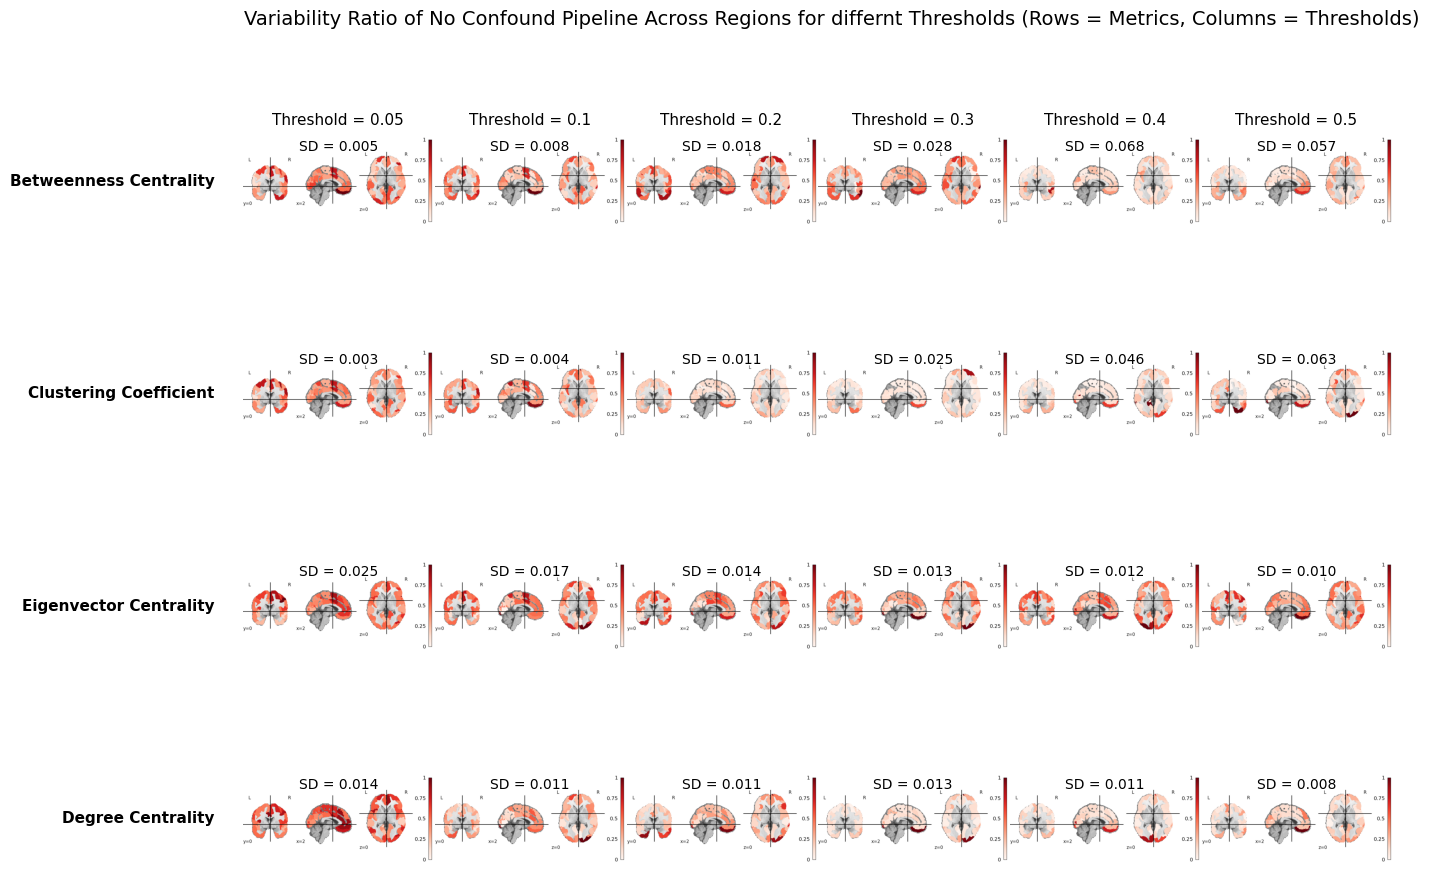

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import image, plotting, datasets
import tempfile
import os
import matplotlib.pyplot as plt

plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 20
})
# --------------------------
# Load Schaefer Atlas (100 regions)
# --------------------------
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
atlas_filename = atlas.maps
atlas_labels = atlas.labels[1:]

# --------------------------
# Your ratio computations (already available)
# --------------------------
ratio1 = cmput_ratio(avrg1_Wconf_num, avrg1_Wconf_anat, 182)
ratio2 = cmput_ratio(avrg2_Wconf_num, avrg2_Wconf_anat, 179)
ratio3 = cmput_ratio(avrg3_Wconf_num, avrg3_Wconf_anat, 176)
ratio4 = cmput_ratio(avrg4_Wconf_num, avrg4_Wconf_anat, 170)
ratio5 = cmput_ratio(avrg5_Wconf_num, avrg5_Wconf_anat, 147)
ratio05 = cmput_ratio(avrg05_Wconf_num, avrg05_Wconf_anat, 182)

ratio_map = {
    "05": ratio05,
    "1": ratio1,
    "2": ratio2,
    "3": ratio3,
    "4": ratio4,
    "5": ratio5
}

thresholds =[0.05, 0.1, 0.2, 0.3, 0.4, 0.5] #[0.1,0.4] # [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
threshold_labels = ["0.05", "0.1", "0.2", "0.3", "0.4", "0.5"] #["0.1","0.4"] #["0.05", "0.1", "0.2", "0.3", "0.4", "0.5"]
metrics = ['betweeness', 'clusteringcoef', 'eigen', 'degree']
metric_labels = ["Betweenness Centrality", "Clustering Coefficient", "Eigenvector Centrality", "Degree Centrality"]

# --------------------------
# Compute SD table
# --------------------------
sd_table = pd.DataFrame(columns=['Threshold', 'Metric', 'Std'])

for thr in thresholds:
    thre = str(thr).split(".")[1] if "." in str(thr) else str(int(thr))
    rPD = ratio_map[thre]
    for i, metric in enumerate(metrics):
        vals = rPD[[c for c in rPD.columns if metric in c]].iloc[0, 0]
        std_val = pd.Series(vals).std()
        sd_table.loc[len(sd_table)] = [thr, metric_labels[i], std_val]

# --------------------------
# Function: map ratios to brain
# --------------------------
def map_ratio_to_brain(ratio_values, atlas_filename):
    atlas_img = image.load_img(atlas_filename)
    atlas_data = atlas_img.get_fdata()
    ratio_values = np.nan_to_num(ratio_values)
    ratio_img_data = np.zeros_like(atlas_data)
    for i, val in enumerate(ratio_values, start=1):
        ratio_img_data[atlas_data == i] = val
    return image.new_img_like(atlas_img, ratio_img_data)

# --------------------------
# Temporary directory for snapshots
# --------------------------
tmpdir = tempfile.mkdtemp()

# --------------------------
# Compute global vmin/vmax for consistent colorbar
# --------------------------
# all_vals = []
# for thr in thresholds:
#     thre = str(thr).split(".")[1] if "." in str(thr) else str(int(thr))
#     rPD = ratio_map[thre]
#     for metric in metrics:
#         vals = rPD[[c for c in rPD.columns if metric in c]].iloc[0, 0]
#         all_vals.extend(vals)
# vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)
# --------------------------
# Generate brain map images and store paths
# --------------------------
image_paths = {metric: [] for metric in metrics}

for metric in metrics:
    for thr in thresholds:
        thre = str(thr).split(".")[1] if "." in str(thr) else str(int(thr))
        rPD = ratio_map[thre]
        ratio_values = rPD[[c for c in rPD.columns if metric in c]].iloc[0, 0]
        # ratio_img = map_ratio_to_brain(ratio_values, atlas_filename)
        vmin, vmax = 0,1 #np.nanmin(ratio_values), np.nanmax(ratio_values) #compute vmin,vmax for each metric separately or select  global vmin/vmax
        # Normalize (0–1 range)
        norm_vals = (ratio_values - np.min(ratio_values)) / (
            np.max(ratio_values) - np.min(ratio_values)
        )
        ratio_img = map_ratio_to_brain(norm_vals, atlas_filename)
        out_path = os.path.join(tmpdir, f"{metric}_thr{thre}.png")
        plotting.plot_stat_map(
            ratio_img,
            display_mode='ortho', #pick view
            cut_coords=[2,0,0],
            cmap='Reds',
            colorbar=True,
            black_bg=False,
            dim=0,
            threshold=0 ,#vmin - 10**-6,
            vmin=vmin,
            vmax=vmax,
            output_file=out_path
        )
        image_paths[metric].append(out_path)
        

# --------------------------
# Assemble figure grid (metrics as rows, thresholds as columns)
# --------------------------
n_rows = len(metrics)
n_cols = len(thresholds)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 10))
plt.subplots_adjust(wspace=0.01, hspace=0.05, left=0.08, right=0.90, bottom=0.08, top=0.92)

for i, metric_label in enumerate(metric_labels):
    metric = metrics[i]
    for j, thr_label in enumerate(threshold_labels):
        img = plt.imread(image_paths[metric][j])
        axes[i, j].imshow(img)
        axes[i, j].axis("off")

        # Column titles: thresholds
        if i == 0:
            axes[i, j].set_title(f"Threshold = {thr_label}", fontsize=11, pad=8)

        # Row labels: metrics
        if j == 0:
            axes[i, j].text(-0.15, 0.5, metric_label,
                            transform=axes[i, j].transAxes,
                            fontsize=11, va='center', ha='right',
                            weight='bold')

        # SD annotation
        sd_value = sd_table.loc[
            (sd_table["Threshold"] == float(thr_label)) &
            (sd_table["Metric"] == metric_label),
            "Std"
        ].values[0]
        axes[i, j].text(0.5, 0.95, f"SD = {sd_value:.3f}",
                        transform=axes[i, j].transAxes,
                        ha='center', va='top', fontsize=10, color='black')

# --------------------------
# Shared colorbar
# --------------------------
# sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
# cbar = fig.colorbar(sm, cax=cbar_ax)
# cbar.set_label("Variability Ratio", rotation=270, labelpad=15)

# --------------------------
# Figure title
# --------------------------
fig.suptitle("Variability Ratio of No Confound Pipeline Across Regions for differnt Thresholds (Rows = Metrics, Columns = Thresholds)", fontsize=14, y=0.99)
plt.show()


[fetch_atlas_schaefer_2018] Dataset found in /home/ubuntu/nilearn_data/schaefer_2018

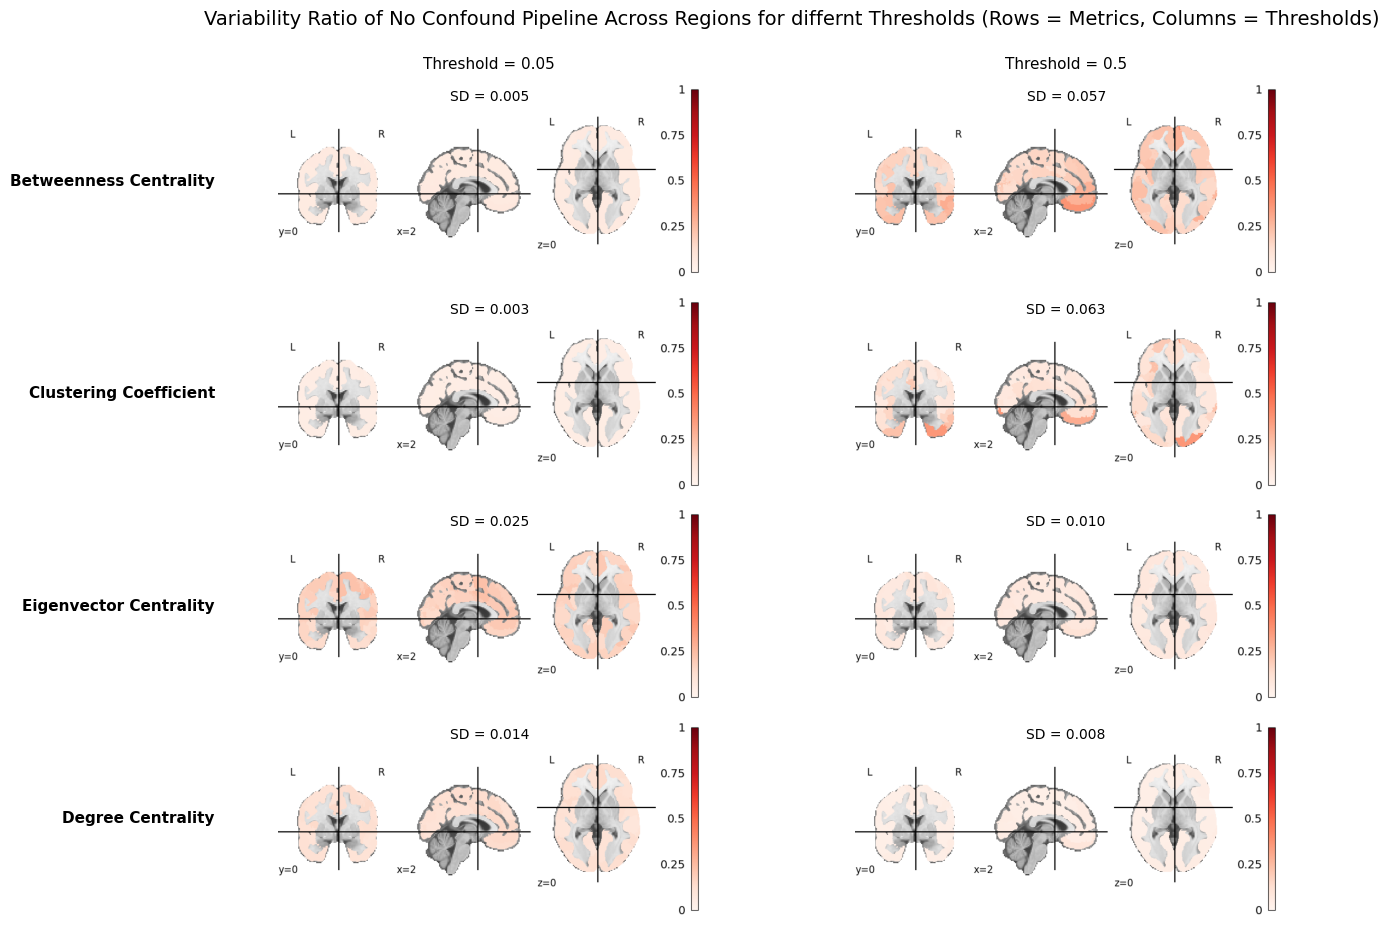

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import image, plotting, datasets
import tempfile
import os
import matplotlib.pyplot as plt

plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 20
})
# --------------------------
# Load Schaefer Atlas (100 regions)
# --------------------------
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
atlas_filename = atlas.maps
atlas_labels = atlas.labels[1:]

# --------------------------
# Your ratio computations (already available)
# --------------------------
ratio1 = cmput_ratio(avrg1_Wconf_num, avrg1_Wconf_anat, 182)
ratio2 = cmput_ratio(avrg2_Wconf_num, avrg2_Wconf_anat, 179)
ratio3 = cmput_ratio(avrg3_Wconf_num, avrg3_Wconf_anat, 176)
ratio4 = cmput_ratio(avrg4_Wconf_num, avrg4_Wconf_anat, 170)
ratio5 = cmput_ratio(avrg5_Wconf_num, avrg5_Wconf_anat, 147)
ratio05 = cmput_ratio(avrg05_Wconf_num, avrg05_Wconf_anat, 182)

ratio_map = {
    "05": ratio05,
 
    "5": ratio5
}

thresholds =[0.05, 0.5] #[0.1,0.4] # [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
threshold_labels = ["0.05",  "0.5"] #["0.1","0.4"] #["0.05", "0.1", "0.2", "0.3", "0.4", "0.5"]
metrics = ['betweeness', 'clusteringcoef', 'eigen', 'degree']
metric_labels = ["Betweenness Centrality", "Clustering Coefficient", "Eigenvector Centrality", "Degree Centrality"]

# --------------------------
# Compute SD table
# --------------------------
sd_table = pd.DataFrame(columns=['Threshold', 'Metric', 'Std'])

for thr in thresholds:
    thre = str(thr).split(".")[1] if "." in str(thr) else str(int(thr))
    rPD = ratio_map[thre]
    for i, metric in enumerate(metrics):
        vals = rPD[[c for c in rPD.columns if metric in c]].iloc[0, 0]
        std_val = pd.Series(vals).std()
        sd_table.loc[len(sd_table)] = [thr, metric_labels[i], std_val]

# --------------------------
# Function: map ratios to brain
# --------------------------
def map_ratio_to_brain(ratio_values, atlas_filename):
    atlas_img = image.load_img(atlas_filename)
    atlas_data = atlas_img.get_fdata()
    ratio_values = np.nan_to_num(ratio_values)
    ratio_img_data = np.zeros_like(atlas_data)
    for i, val in enumerate(ratio_values, start=1):
        ratio_img_data[atlas_data == i] = val
    return image.new_img_like(atlas_img, ratio_img_data)

# --------------------------
# Temporary directory for snapshots
# --------------------------
tmpdir = tempfile.mkdtemp()

# --------------------------
# Compute global vmin/vmax for consistent colorbar
# --------------------------
# all_vals = []
# for thr in thresholds:
#     thre = str(thr).split(".")[1] if "." in str(thr) else str(int(thr))
#     rPD = ratio_map[thre]
#     for metric in metrics:
#         vals = rPD[[c for c in rPD.columns if metric in c]].iloc[0, 0]
#         all_vals.extend(vals)
# vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)
# --------------------------
# Generate brain map images and store paths
# --------------------------
image_paths = {metric: [] for metric in metrics}

for metric in metrics:
    for thr in thresholds:
        thre = str(thr).split(".")[1] if "." in str(thr) else str(int(thr))
        rPD = ratio_map[thre]
        ratio_values = rPD[[c for c in rPD.columns if metric in c]].iloc[0, 0]
        ratio_img = map_ratio_to_brain(ratio_values, atlas_filename)
        vmin, vmax = 0,1 #np.nanmin(ratio_values), np.nanmax(ratio_values) #compute vmin,vmax for each metric separately or select  global vmin/vmax
        # Normalize (0–1 range)
        out_path = os.path.join(tmpdir, f"{metric}_thr{thre}.png")
        plotting.plot_stat_map(
            ratio_img,
            display_mode='ortho', #pick view
            cut_coords=[2,0,0],
            cmap='Reds',
            colorbar=True,
            black_bg=False,
            dim=0,
            threshold=0 ,#vmin - 10**-6,
            vmin=vmin,
            vmax=vmax,
            output_file=out_path
        )
        image_paths[metric].append(out_path)
        

# --------------------------
# Assemble figure grid (metrics as rows, thresholds as columns)
# --------------------------
n_rows = len(metrics)
n_cols = len(thresholds)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 10))
plt.subplots_adjust(wspace=0.01, hspace=0.05, left=0.08, right=0.90, bottom=0.08, top=0.92)

for i, metric_label in enumerate(metric_labels):
    metric = metrics[i]
    for j, thr_label in enumerate(threshold_labels):
        img = plt.imread(image_paths[metric][j])
        axes[i, j].imshow(img)
        axes[i, j].axis("off")

        # Column titles: thresholds
        if i == 0:
            axes[i, j].set_title(f"Threshold = {thr_label}", fontsize=11, pad=8)

        # Row labels: metrics
        if j == 0:
            axes[i, j].text(-0.15, 0.5, metric_label,
                            transform=axes[i, j].transAxes,
                            fontsize=11, va='center', ha='right',
                            weight='bold')

        # SD annotation
        sd_value = sd_table.loc[
            (sd_table["Threshold"] == float(thr_label)) &
            (sd_table["Metric"] == metric_label),
            "Std"
        ].values[0]
        axes[i, j].text(0.5, 0.95, f"SD = {sd_value:.3f}",
                        transform=axes[i, j].transAxes,
                        ha='center', va='top', fontsize=10, color='black')

# --------------------------
# Shared colorbar
# --------------------------
# sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
# cbar = fig.colorbar(sm, cax=cbar_ax)
# cbar.set_label("Variability Ratio", rotation=270, labelpad=15)

# --------------------------
# Figure title
# --------------------------
fig.suptitle("Variability Ratio of No Confound Pipeline Across Regions for differnt Thresholds (Rows = Metrics, Columns = Thresholds)", fontsize=14, y=0.99)
plt.show()
